# Changes:
1. Create a Pytorch Dataloader
2. Normalize input
3. Make the code runnable on Google Colab

In [2]:
!pip install torch torchvision

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x588de000 @  0x7f28516cc1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.1MB/s 
    100% |████████████████████████████████| 2.0MB 3.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [3]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 6.7MB/s 


In [4]:
! git clone https://github.com/allen-q/pytorch-learning.git

Cloning into 'pytorch-learning'...
remote: Counting objects: 766, done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 766 (delta 17), reused 27 (delta 9), pack-reused 721
Receiving objects: 100% (766/766), 294.62 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (286/286), done.


In [5]:
cd pytorch-learning/kaggle/salt/

/content/pytorch-learning/kaggle/salt


In [ ]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_test_0.npy

#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_test_1.npy

#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_train_all.npy

#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_train_all_mask.npy

In [ ]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle

% matplotlib inline

In [ ]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor


In [9]:
dtype

torch.cuda.FloatTensor

In [ ]:
def rle_encoder2d(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    s = pd.Series(x.clip(0,1).flatten('F'))
    s.index = s.index+1
    df = s.to_frame('pred').assign(zero_cumcnt=s.eq(0).cumsum())
    df = df.loc[df.pred.gt(0)]
    df_rle = df.reset_index().groupby('zero_cumcnt').agg({'index': min, 'pred': sum}).astype(int).astype(str)
    rle = ' '.join((df_rle['index'] + ' '+df_rle['pred']).tolist())
    
    return rle

In [ ]:
def rle_encoder3d(x):   
    return np.r_[[rle_encoder2d(e) for e in x]]

In [ ]:
def load_img_to_np(img_path, num_channel=1):
    images = []
    img_ids = []
    for filename in sorted(glob.glob(f'{img_path}/*.png')): #assuming png
        img_id = filename.split('\\')[-1].split('.')[0]
        img_ids.append(img_id)
        images.append(np.array(imageio.imread(filename), dtype=np.uint8).reshape(101,101,-1)[:,:,0:num_channel])
    return (np.r_[images], img_ids)

In [ ]:
def load_single_img(path, show=False):
    img = np.array(imageio.imread(path), dtype=np.uint8)
    if show:
        plt.imshow(img, cmap='gray')
    return img

In [ ]:
def format_train_data(X):
    X = np.moveaxis(X, -1,1)
    X = np.pad(X, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    return torch.from_numpy(X).float()

In [ ]:
def get_train_batch(X_train, y_train, batch_size):
    batch_ids = np.random.choice(len(X_train), batch_size, replace=False)
    X_train_batch = X_train[batch_ids]
    X_train_batch = np.moveaxis(X_train_batch, -1,1)
    X_train_batch = np.pad(X_train_batch, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    y_train_batch = np.clip(y_train[batch_ids],0,1)
    
    return (torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float())

In [ ]:
def calc_raw_iou(a, b):
    if isinstance(a, torch.Tensor):
        a = a.cpu().detach().numpy()
    if isinstance(b, torch.Tensor):
        b = b.cpu().detach().numpy()
    a = np.clip(a, 0, 1)
    b = np.clip(b, 0, 1)
    u = np.sum(np.clip(a+b, 0, 1), (1,2)).astype(np.float)
    i = np.sum(np.where((a+b)==2, 1, 0), (1,2)).astype(np.float)
    with np.errstate(divide='ignore',invalid='ignore'):
        iou = np.where(i==u, 1, np.where(u==0, 0, i/u))
        
    return iou

In [ ]:
def calc_mean_iou(a, b):
    thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    iou = calc_raw_iou(a, b)
    iou_mean = (iou[:,None]>thresholds).mean(1).mean()

    return iou_mean

In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def get_current_time_as_fname():
        timestamp = (
                dt.datetime.now(pytz.timezone('Australia/Melbourne'))
                .strftime('%Y_%m_%d_%H_%M_%S')
                )
                
        return timestamp

In [ ]:
def plot_img_mask_pred(image, mask, pred=None):
    if isinstance(image, torch.Tensor):
        image = image.detach().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().numpy()
    image = image.squeeze()
    mask = mask.squeeze()
    if pred is None:
        f, axarr = plt.subplots(1,2)
    else:
        f, axarr = plt.subplots(1,3)        
    axarr[0].imshow(image, cmap='gray')
    axarr[1].imshow(mask, cmap='gray')    
    axarr[0].grid()
    axarr[1].grid()    
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    if pred is not None:
        axarr[2].imshow(pred, cmap='gray')
        axarr[2].grid()
        axarr[2].set_title('Predicted Mask')
    plt.show()

In [ ]:
class SigToBinary(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, X):
        return X.ge(0.5)
    

In [ ]:
class SaltNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1,64,3, padding=10),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        out = self.seq(X)
        return torch.clamp(out[:,:,:-1,:-1].squeeze(), 0.0, 1.0)

In [ ]:
def adjust_predictions(zero_mask_cut_off, X, y_pred, y=None):
    if isinstance(X, torch.Tensor):
        X = X.cpu().detach().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().detach().numpy()
    y_pred_adj = y_pred.clip(0,1)

    # Set predictions to all 0 for black images
    black_img_mask = (X.mean((1,2,3)) == 0)
    y_pred_adj[black_img_mask]=0

    # set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
    y_pred_adj = np.r_[[e if e.sum()>zero_mask_cut_off else np.zeros_like(e) for e in y_pred_adj]]
    
    if y is not None:
        print(f'IOU score before: {calc_mean_iou(y_pred, y)}, IOU Score after:{calc_mean_iou(y_pred_adj, y)}')
        
    return y_pred_adj

In [ ]:
def show_img_grid():
    pass
    #plt.imshow(torchvision.utils.make_grid(torch.from_numpy(y_train_black).unsqueeze(1)).permute(1, 2, 0))

## Constant and Parameter Defination

In [ ]:
ZERO_MASK_CUTOFF = 120

## Load Data

## Load train and test data from npy files or from raw images if npy files not exist.

In [26]:
try:
    print('Try loading data from npy and pickle files...')
    np_train_all = np.load('./data/np_train_all.npy')
    np_train_all_mask = np.load('./data/np_train_all_mask.npy')
    np_test = np.concatenate([np.load('./data/np_test_0.npy'), np.load('./data/np_test_1.npy')])
    with open('./data/misc_data.pickle', 'rb') as f:
        misc_data = pickle.load(f)
    print('Data loaded.')
except:
    print('npy files not found. Reload data from raw images...')
    np_train_all, np_train_all_ids = load_img_to_np('./data/train/images')
    np_train_all_mask, np_train_all_mask_ids = load_img_to_np('./data/train/masks')
    df_train_all_depth = pd.read_csv('./data/depths.csv').set_index('id')
    np_test, np_test_ids = load_img_to_np('./data/test/images')
    np.save('./data/np_train_all.npy', np_train_all)
    np.save('./data/np_train_all_mask.npy', np_train_all_mask)
    for k, v in enumerate(np.split(np_test,2)):
        np.save(f'./data/np_test_{k}.npy', v)
    misc_data = {'df_train_all_depth': df_train_all_depth,
                 'np_train_all_ids': np_train_all_ids,
                 'np_train_all_mask_ids': np_train_all_mask_ids,
                 'np_test_ids': np_test_ids}
    with open('./data/misc_data.pickle', 'wb') as f:
        pickle.dump(misc_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('Data loaded.')

Try loading data from npy and pickle files...
Data loaded.


## Train Val data split

In [ ]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [ ]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
X_train_mean_img = X_train.mean(0).astype(np.float32)

In [ ]:
# Balck image example
#plt.imshow(np_train_all[misc_data['np_train_all_ids'].index('0d8ed16206')].squeeze(), cmap='gray')

In [ ]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X_orig = self.np_img[idx]
        X = X_orig - self.mean_img
        #print(X.dtype)
        X = np.moveaxis(X, -1,0)
        
        X = np.pad(X, [(0, 0),(0, 1), (0, 1)], mode='constant')
        #print(X.dtype)
        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx].clip(0,1)
        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        X = torch.from_numpy(X).float().type(dtype)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        if self.transform:
            X = self.transform(X)
        #from boxx import g
        #g()
        return (X,y,d,idx)

In [ ]:
data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

In [ ]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img), **data_params)

In [ ]:
t = iter(train_dataLoader).__next__()

In [35]:
len(t)

4

In [ ]:
class IOU_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y):
        #print(y_pred.requires_grad)
        #y_pred = torch.where(y_pred.ge(0.5), torch.tensor(1.0), torch.tensor(0.0))
        i = y_pred.mul(y)
        u = (y_pred + y) - i
        mean_iou = torch.mean(i.view(i.shape[0],-1).sum(1) / u.view(i.shape[0],-1).sum(1))
        iou_loss = 1 - mean_iou
        #from boxx import g
        #g()
        
        return iou_loss

## Create a Model

In [ ]:
saltnet = SaltNet()

In [ ]:
loss_fn_bce = nn.BCELoss()
loss_fn_iou = IOU_Loss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

In [ ]:
start = time.time()

In [ ]:
TRAIN_MODE = True

In [79]:
list(saltnet.parameters())[0].sum()

tensor(-4.6157, grad_fn=<SumBackward0>)

In [ ]:
list(saltnet.parameters())[-1].grad

In [ ]:
#X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=2)

In [ ]:
max_epochs = 100
iter_count = 0
all_losses = []

In [ ]:
if torch.cuda.is_available():
    saltnet.cuda()

Total Loss is 1.553637981414795, BCE loss is 0.7041831016540527, IOU loss is 0.8494548797607422, IOU is 0.0125 at iter 0, Time: 0m 15s


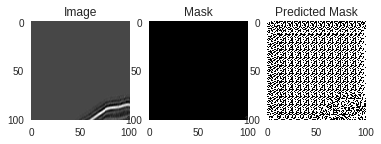

Total Loss is 1.3278148293495178, BCE loss is 0.4930013120174408, IOU loss is 0.7721542716026306, IOU is 0.1875 at iter 50, Time: 0m 20s


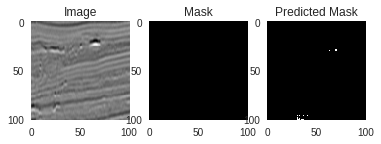

Total Loss is 1.1973934948444367, BCE loss is 0.31101560592651367, IOU loss is 0.7133103609085083, IOU is 0.23750000000000002 at iter 100, Time: 0m 25s


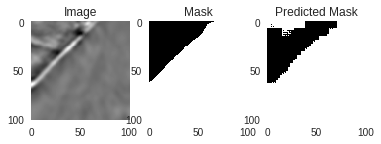

Total Loss is 1.112836804986, BCE loss is 0.31686529517173767, IOU loss is 0.7050700783729553, IOU is 0.265625 at iter 150, Time: 0m 30s


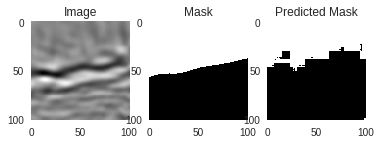

Total Loss is 1.1039474070072175, BCE loss is 0.5416131615638733, IOU loss is 0.7475639581680298, IOU is 0.271875 at iter 200, Time: 0m 35s


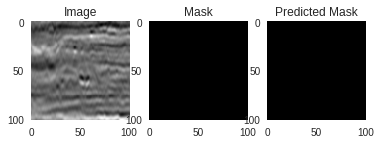

Total Loss is 1.0587089747190475, BCE loss is 0.2917855978012085, IOU loss is 0.7224893569946289, IOU is 0.2875 at iter 250, Time: 0m 40s


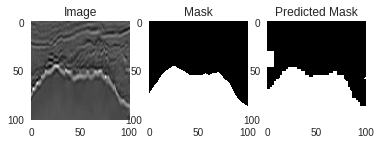

Total Loss is 1.0433381021022796, BCE loss is 0.49265629053115845, IOU loss is 0.7676334381103516, IOU is 0.278125 at iter 300, Time: 0m 45s


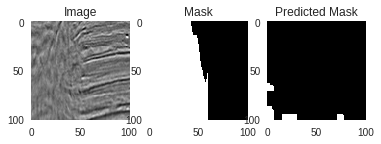

Total Loss is 1.0583120346069337, BCE loss is 0.31834983825683594, IOU loss is 0.7885887622833252, IOU is 0.321875 at iter 350, Time: 0m 51s


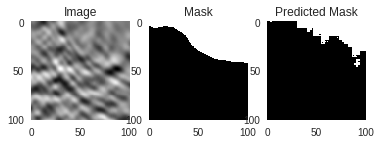

Total Loss is 1.0314001947641374, BCE loss is 0.4852648675441742, IOU loss is 0.7229094505310059, IOU is 0.3625 at iter 400, Time: 0m 56s


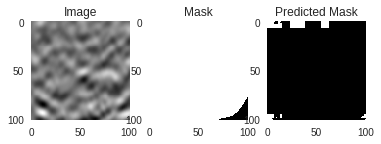

Total Loss is 0.9961377501487731, BCE loss is 0.4092445969581604, IOU loss is 0.6771334409713745, IOU is 0.334375 at iter 450, Time: 1m 1s


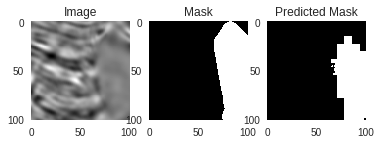

Total Loss is 1.009263664484024, BCE loss is 0.3078399896621704, IOU loss is 0.5999549627304077, IOU is 0.43437499999999996 at iter 500, Time: 1m 6s


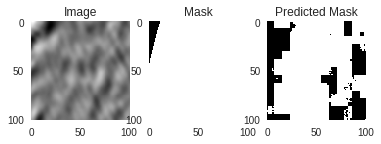

Total Loss is 1.0018680334091186, BCE loss is 0.3173253834247589, IOU loss is 0.717491626739502, IOU is 0.290625 at iter 550, Time: 1m 11s


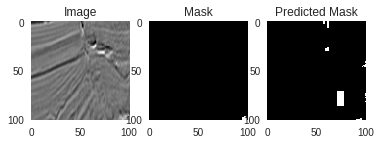

Total Loss is 0.9659960031509399, BCE loss is 0.23288200795650482, IOU loss is 0.6696227192878723, IOU is 0.353125 at iter 600, Time: 1m 16s


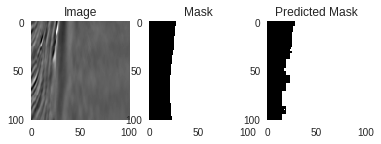

Total Loss is 0.9729932337999344, BCE loss is 0.28795334696769714, IOU loss is 0.6728737354278564, IOU is 0.40625 at iter 650, Time: 1m 21s


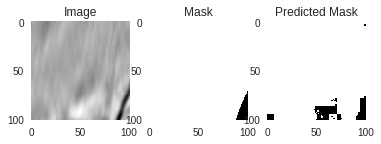

Total Loss is 0.9456177145242691, BCE loss is 0.2849694788455963, IOU loss is 0.649217963218689, IOU is 0.371875 at iter 700, Time: 1m 26s


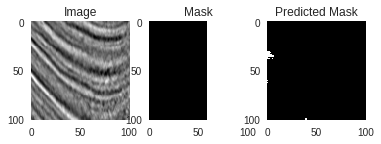

Total Loss is 0.9739322990179062, BCE loss is 0.27930721640586853, IOU loss is 0.7072405815124512, IOU is 0.31875 at iter 750, Time: 1m 31s


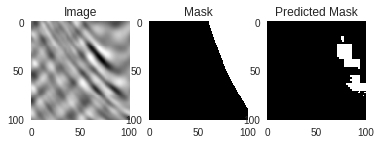

Total Loss is 0.9371498167514801, BCE loss is 0.29210278391838074, IOU loss is 0.6379081010818481, IOU is 0.36874999999999997 at iter 800, Time: 1m 37s


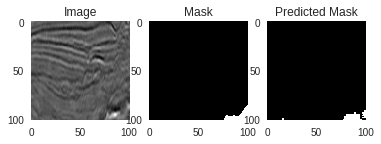

Total Loss is 0.9557679384946823, BCE loss is 0.3643053472042084, IOU loss is 0.7338056564331055, IOU is 0.328125 at iter 850, Time: 1m 42s


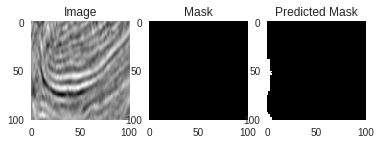

Total Loss is 0.9650163978338242, BCE loss is 0.3116288483142853, IOU loss is 0.6675916910171509, IOU is 0.275 at iter 900, Time: 1m 47s


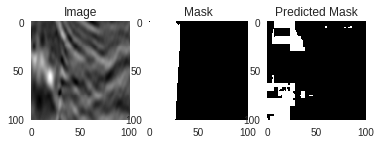

Total Loss is 0.9812974184751511, BCE loss is 0.2832517921924591, IOU loss is 0.7399699687957764, IOU is 0.39375000000000004 at iter 950, Time: 1m 52s


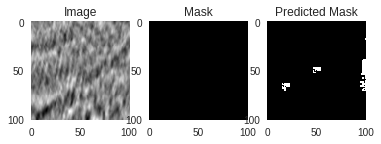

Total Loss is 0.9014168560504914, BCE loss is 0.2711625099182129, IOU loss is 0.5978785157203674, IOU is 0.31875 at iter 1000, Time: 1m 57s


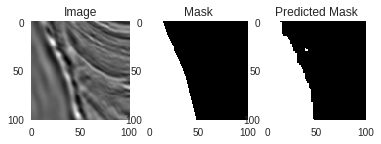

Total Loss is 1.0111212730407715, BCE loss is 0.33776789903640747, IOU loss is 0.767943799495697, IOU is 0.22187500000000002 at iter 1050, Time: 2m 2s


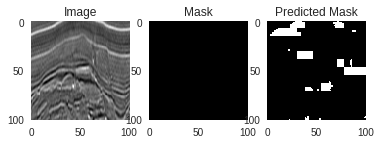

Total Loss is 0.9147820234298706, BCE loss is 0.4171591103076935, IOU loss is 0.6419998407363892, IOU is 0.296875 at iter 1100, Time: 2m 7s


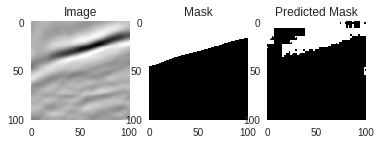

Total Loss is 0.9101959943771363, BCE loss is 0.18608927726745605, IOU loss is 0.6674326062202454, IOU is 0.46875 at iter 1150, Time: 2m 12s


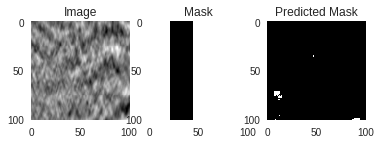

Total Loss is 0.9196984469890594, BCE loss is 0.33690378069877625, IOU loss is 0.632468581199646, IOU is 0.3125 at iter 1200, Time: 2m 17s


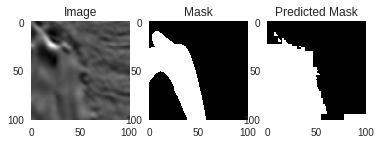

Total Loss is 0.8703991830348968, BCE loss is 0.1827973574399948, IOU loss is 0.6384390592575073, IOU is 0.42812500000000003 at iter 1250, Time: 2m 23s


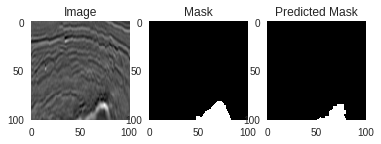

Total Loss is 0.9476574152708054, BCE loss is 0.312370240688324, IOU loss is 0.7070333957672119, IOU is 0.29375 at iter 1300, Time: 2m 28s


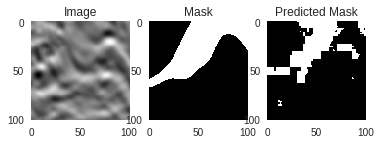

Total Loss is 0.9153176516294479, BCE loss is 0.26369136571884155, IOU loss is 0.5954641103744507, IOU is 0.47187500000000004 at iter 1350, Time: 2m 33s


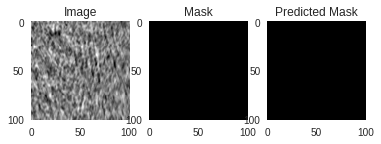

Total Loss is 0.9234296143054962, BCE loss is 0.3167775869369507, IOU loss is 0.5433010458946228, IOU is 0.45 at iter 1400, Time: 2m 38s


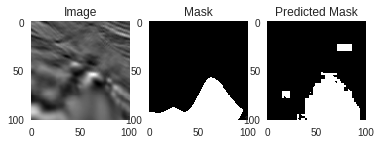

Total Loss is 0.9084911704063415, BCE loss is 0.32778865098953247, IOU loss is 0.7120485901832581, IOU is 0.3375 at iter 1450, Time: 2m 43s


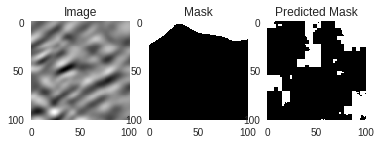

Total Loss is 0.8775291740894318, BCE loss is 0.24402065575122833, IOU loss is 0.7240291237831116, IOU is 0.221875 at iter 1500, Time: 2m 48s


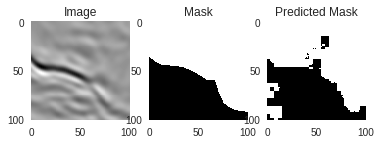

Total Loss is 0.9223090052604676, BCE loss is 0.3016423285007477, IOU loss is 0.7712844610214233, IOU is 0.196875 at iter 1550, Time: 2m 53s


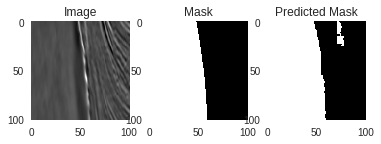

Total Loss is 0.899513253569603, BCE loss is 0.2408832460641861, IOU loss is 0.7817171812057495, IOU is 0.24375000000000002 at iter 1600, Time: 2m 58s


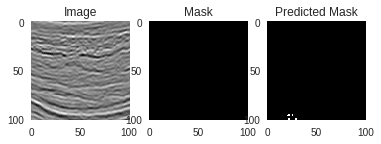

Total Loss is 0.8950008392333985, BCE loss is 0.1648329198360443, IOU loss is 0.6256861686706543, IOU is 0.4625 at iter 1650, Time: 3m 4s


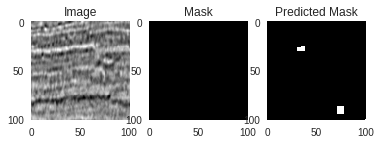

In [ ]:
if TRAIN_MODE:
    for epoch in range(max_epochs):
        
        for X_batch, y_batch, d_batch, X_id in train_dataLoader:
            #y_pred = torch.tensor(saltnet(X_batch).ge(0.5).float(), requires_grad=True)

            y_pred = saltnet(X_batch)
            optimizer.zero_grad()
            loss_bce = loss_fn_bce(y_pred, y_batch.float())
            loss_iou = loss_fn_iou(y_pred, y_batch.float())
            loss = loss_bce + loss_iou
            loss.backward()
            optimizer.step()
            all_losses.append(loss.item())

            #from boxx import g
            #g()
            if iter_count % 50 == 0:
                iou_batch = calc_mean_iou(y_pred.ge(0.5), y_batch.float())
                print(f'Total Loss is {np.mean(all_losses[-20:])}, BCE loss is {loss_bce}, IOU loss is {loss_iou}, IOU is {iou_batch} at iter {iter_count}, Time: {timeSince(start)}')
                plot_img_mask_pred(X_train[X_id[0]].squeeze(), y_train[X_id[0]].squeeze(), y_pred[0].squeeze().gt(0.5))

            iter_count+=1

In [ ]:
epoch

0

In [ ]:
if TRAIN_MODE:
    state = {'epoch': epoch + 1, 
             'state_dict': saltnet.state_dict(),
             'optimizer': optimizer.state_dict()}
    ckp_name = f'./models/saltnet_{get_current_time_as_fname()}.ckp'
    torch.save(state, ckp_name)

In [ ]:
ckp_name

'./models/saltnet_2018_08_17_13_30_29.ckp'

## Load checkpoint

In [ ]:
state = torch.load('./models/saltnet_2018_08_17_13_30_29.ckp')

In [ ]:
state.keys()

dict_keys(['epoch', 'state_dict', 'optimizer'])

In [ ]:
saltnet.load_state_dict(state['state_dict'])

### Set model to evaluation mode

In [46]:
saltnet.eval()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [ ]:
assert saltnet.training == False

### Make Predictions on validation set

In [ ]:
#X_val = X_val[:64]
#y_val = y_val[:64]
#depth_val = depth_val[:64]

In [ ]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img), batch_size=64)

In [ ]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(saltnet(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

In [68]:
y_val_pred.shape

torch.Size([800, 101, 101])

Image ID: 769


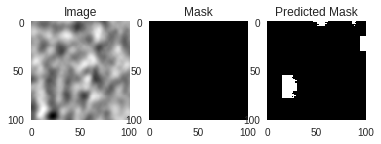

Image ID: 774


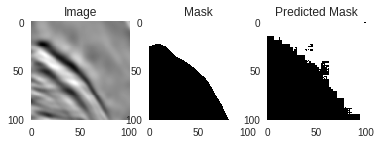

In [69]:
for i in range(2):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(0.5)[rand_id]
    plot_img_mask_pred(val_img, val_mask, val_mask_pred)

In [70]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(0.5), y_val.squeeze())

IOU score before: 0.3235, IOU Score after:0.48450000000000004


In [74]:
y_val_pred_adj = adjust_predictions(1500, X_val, y_val_pred.gt(0.5), y_val.squeeze())

IOU score before: 0.3235, IOU Score after:0.5505


## Make predictions on test set

In [ ]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(np_test[:100], None, depth_test, X_train_mean_img), batch_size=64)

In [ ]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(saltnet(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

In [ ]:
#y_test_pred = y_test_pred_raw.ge(0.5).detach().numpy()

### Show segmentation masks for a few images

Image ID: 93


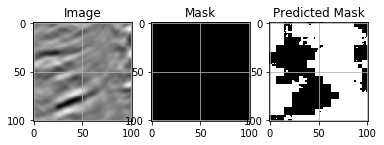

Image ID: 77


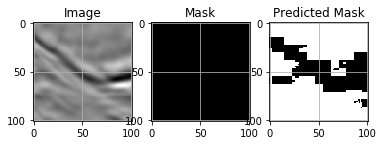

In [ ]:
for i in range(2):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = np_test[rand_id]
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred(img, np.zeros_like(mask_pred), mask_pred)

### Adjust predictions

In [ ]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, np_test[X_test_id_batch], y_test_pred[X_test_id_batch].gt(0.5))

### Encode predictions using RLE(Run Length Encoding) method

In [ ]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [ ]:
test_dataLoader

In [ ]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'][:100], data=y_test_pred_rle).reset_index()

In [ ]:
df_test_rle.columns = ['id', 'rle_mask']

In [ ]:
df_test_rle[df_test_rle.rle_mask==''].shape

(81, 2)

In [ ]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)